In [32]:
import numpy as np
import re

In [33]:
from utility.clean_data_func import clean_and_filter_data


def remove_special_characters(text):
    """Removes special characters from a text string."""
    pattern = r"[^\w\s]"  # Keep alphanumeric characters and whitespace
    return re.sub(pattern, "", text)


def lowercase(text):
    """Converts a text string to lowercase."""
    return text.lower()


# Clean data
print("Clean data")
df = clean_and_filter_data("./utility/azarbeijan-reviews.csv")
df["content"] = df["content"].apply(remove_special_characters)
df["content"] = df["content"].apply(lowercase)

# Separate target and data
print("Separate target and data")
content = df["content"].values.tolist()
score = df["score"].values.tolist()

# Split the dataset into training and testing sets
print("Split the dataset into training and testing sets")
split_point = int(len(content) * 0.80)
train_content, test_content = content[:split_point], content[split_point:]
train_score, test_score = score[:split_point], score[split_point:]

Clean data
                                             content  score  upvotes
0                                          Çox qəşəy      5        0
1  Men niye nomre ile qeydiyatdan kece bilmirem.....      1        0
2  Salam. Mən yukluyə bilmirəm. Necə kömək edə bi...      5        0
3                                          cox gözəl      5        1
4  Xaiş edirem bu problemi hell edinde həftədə 2 ...      5        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127537 entries, 0 to 127536
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  127534 non-null  object
 1   score    127537 non-null  int64 
 2   upvotes  127537 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ MB
None
content    3
score      0
upvotes    0
dtype: int64
Separate target and data
Split the dataset into training and testing sets


In [34]:
import numpy as np

def load_glove_model(glove_file):
    print("Loading GloVe Model")
    with open(glove_file, 'r', encoding='utf-8') as f:
        embeddings_index = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            embeddings_index[word] = embedding
    print("Done.", len(embeddings_index), " words loaded!")
    return embeddings_index

glove_path = './glove.6B.100d.txt'
glove_model = load_glove_model(glove_path)


Loading GloVe Model
Done. 400000  words loaded!


In [35]:
def sentence_vector(sentence, model):
    words = sentence.split()  # Assuming default whitespace tokenization
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        # If no words in the sentence are in the model, return zero vector.
        return np.zeros(len(model[next(iter(model))]))
    return np.mean(word_vectors, axis=0)

# Apply this function to each row in the DataFrame
df['vector'] = df['content'].apply(lambda x: sentence_vector(x, glove_model))

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Example assumes 'score' needs to be encoded for classification
encoder = LabelEncoder()
encoded_scores = encoder.fit_transform(df['score'])

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['vector'].values), encoded_scores, test_size=0.2, random_state=42)


In [37]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(encoded_scores)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/Users/hasaneke/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.6010 - loss: 1.1459 - val_accuracy: 0.6184 - val_loss: 1.0333
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6192 - loss: 1.0416 - val_accuracy: 0.6184 - val_loss: 1.0239
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6251 - loss: 1.0241 - val_accuracy: 0.6162 - val_loss: 1.0219
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.6075 - loss: 1.0352 - val_accuracy: 0.6187 - val_loss: 1.0179
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6185 - loss: 1.0261 - val_accuracy: 0.6184 - val_loss: 1.0188
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.6167 - loss: 1.0193 - val_accuracy: 0.6198 - val_loss: 1.0148
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.6264 - loss: 1.0086 - val_accuracy: 0.6184 - val_loss: 1.0191
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.6180 - loss: 1.0098 - 

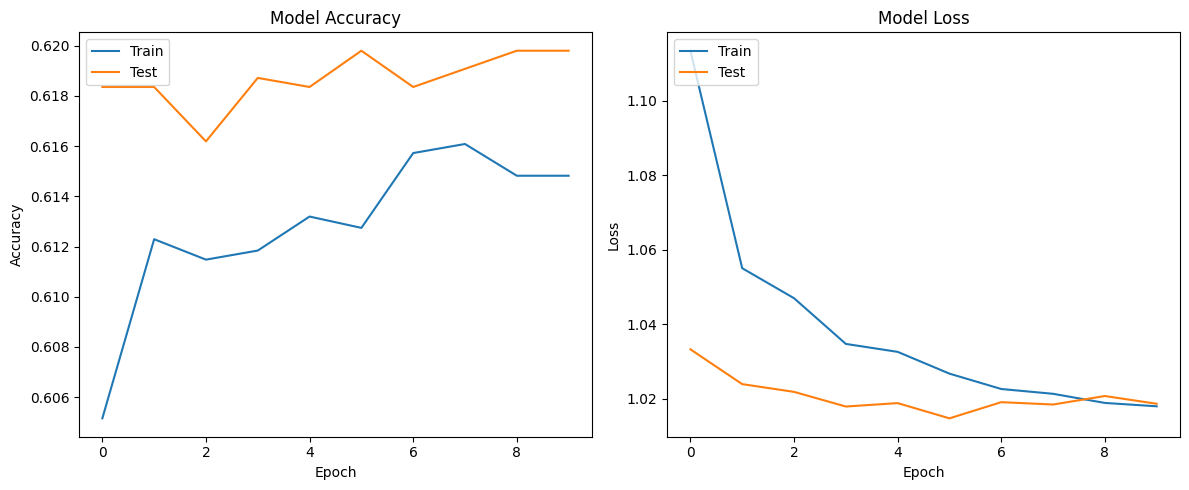

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Model Accuracy Graph
Training Accuracy: This line starts around 0.608 and fluctuates as the epochs increase, peaking near epoch 6 before dropping slightly. It exhibits some variability but generally shows an upward trend in the first half of the training process.
Test Accuracy: The test accuracy starts slightly higher than the training accuracy, and it maintains a relatively stable trend throughout the epochs. It appears to be consistently higher than the training accuracy, which is unusual in typical training scenarios as it suggests that the model might not be overfitting but rather underfitting or not effectively learning from the training data.

Model Loss Graph
Training Loss: Starts from a high value of around 1.10 and dramatically drops, showing significant improvement in the first couple of epochs. It then gradually decreases, suggesting ongoing learning and improvements in fitting the training data.
Test Loss: The test loss shows a very different pattern; it begins lower than the training loss, decreases slightly, and then flattens out. The test loss remains consistently below the training loss throughout the epochs.